In [1]:
import xarray as xr
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np

In [2]:
swb1_dir = '../swb1/'
swb_dir = '../swb2/'

# suppress exponential notation in plotting format
plt.rcParams['axes.formatter.useoffset'] = False
%matplotlib inline

In [3]:
comparison_cell_dict = {#'Deciduous_forest':['96','44','553927','459454'],
                        'Evergreen_forest':['128','65','556791','457569'],
#                        'Potato_field':['177','202','561167','445224'],
                        'Rye':['9','277','546094','438492'],
                        'Corn':['115','319','555602','434644'],
                        'Winter_wheat':['254','56','568129','458340'],
                        'Sugar_beets': ['283','203','570741','445112']}

soil_variable_pairs = {1: ['potential_recharge','net_infiltration'],
                       2: ['ref_et0','reference_ET0'],
                       3: ['soil_storage','soil_storage'],
                       4: ['interception','interception'],
                       5: ['irrigation','irrigation'],
                       6: ['bare_soil_evap','bare_soil_evap'],
                       7: ['kcb','crop_coefficient_kcb'],
                       8: ['current_rooting_depth','current_rooting_depth'],
                       9: ['plant_stress_coef_ks','plant_stress_coef_ks'],
                      10: ['total_available_water','total_available_water'],
                      11: ['readily_available_water','readily_available_water'],
                      12: ['evap_reduction_coef_kr','evap_reduction_coef_kr'], 
                      13: ['surf_evap_coef_ke','surf_evap_coef_ke'],
#                      14: ['sm_deficit','soil_moisture_deficit'],
                      15: ['snowmelt','snowmelt'],
                      16: ['snow_cover','snow_storage'],
                      17: ['runoff','runoff'],
                      18: ['crop_etc','crop_etc'],
                      19: ['gross_precip','gross_precip']}

precip_variable_pairs = {1: ['potential_recharge','net_infiltration'],
                       2: ['soil_storage','soil_storage'],
                       3: ['interception','interception'],
                       4: ['irrigation','irrigation'],
                       5: ['snowmelt','snowmelt'],
                       6: ['net_rainfall','net_rainfall'],  
                       7: ['snow_cover','snow_storage'],
                       8: ['runoff','runoff']}

atmos_variable_pairs = {1: ['tmin','tmin'],
                        2: ['tmax','tmax'],
                        3: ['tmean','tmean'],
                        4: ['snow_cover','snow_storage']}


landuse_codes = {141:'Deciduous forest',
                 142:'Evergreen forest',
                  43:'Potato'}

In [4]:
def filter_nan(s,o):
    """
    this functions removed the data  from simulated and observed data
    whereever the observed data contains nan
    
    this is used by all other functions, otherwise they will produce nan as 
    output
    """
    if np.sum(~np.isnan(s*o))>=1:
        data = np.array([s,o])
        data = np.transpose(data)
        data = data[~np.isnan(data).any(1)]
        s = data[:,0]
        o = data[:,1]
    return s, o

In [5]:
def bias(s,o):
    """
    Bias
    input:
        s: simulated
        o: observed
    output:
        bias: bias
    """
    s,o = filter_nan(s,o)
    return np.mean(s-o)

def NS(s,o):
    """
    Nash Sutcliffe efficiency coefficient
    input:
        s: simulated
        o: observed
    output:
        ns: Nash Sutcliffe efficient coefficient
    """
    s,o = filter_nan(s,o)
    return 1 - sum((s-o)**2)/sum((o-np.mean(o)+1.0e-10)**2)

In [6]:
def read_swb1_csv( colnum, rownum ):
    filename = 'SWB_variable_values__col_' + colnum + '__row_' + rownum + '.csv'
    df = pd.read_csv(swb1_dir + filename, skipinitialspace=True,index_col=False)
    df.reindex()
    df = df.assign(date=pd.to_datetime(df[['year','month','day']]))
    return df

In [7]:
def read_swb2_csv( colnum, rownum, xcoord, ycoord ):
    filename = 'SWB2_variable_values__col_' + colnum + '__row_' + rownum + '__x_' + xcoord + '__y_' + ycoord + '.csv'
    df = pd.read_csv(swb_dir + filename, skipinitialspace=True,index_col=False)
    df.reindex()
    df = df.assign(date=pd.to_datetime(df[['year','month','day']]))
    return df

In [8]:
def create_joined_subset(swb1_df, swb2_df, swb1_colname, swb2_colname):
    swb1_ss = swb1_df.filter(['date', swb1_colname]) 
    swb2_ss = swb2_df.filter(['date', swb2_colname]) 
    comparison_df = pd.merge(swb1_ss,
                             swb2_ss,
                             left_on=swb1_ss.date, 
                             right_on=swb2_ss.date).drop(columns=['date_y'])
    comparison_df.columns=["date", "swb1_"+swb1_colname, "swb2_"+swb2_colname]
    return(comparison_df)

In [9]:
def make_plots( swb1_daily, swb2_daily, description ):
    for key, value in variable_pairs.items():
        swb1_fieldname = value[0]
        swb2_fieldname = value[1]
        cc = create_joined_subset(swb1_daily, swb2_daily, swb1_fieldname, swb2_fieldname)
        ns = NS(cc.iloc[:,1],cc.iloc[:,2])
        if cc.count()[0] > 0 and ns < 0.99:
    #        slope, intercept, r_value, p_value, std_err = stats.linregress(cc.iloc[:,1], cc.iloc[:,2])
    #            if( slope > 0.0 and r_value < 0.9 ):
            lu_code = swb2_daily.landuse_code[0]
            lu_desc = landuse_codes.get(lu_code)
            title_txt = swb2_fieldname + ":  " + str(lu_code) + " - " + description + "  NS=",str(ns)
            fig, axes = plt.subplots(1,2,figsize=(17,12))
            fig.constrained_layout=True
            fig.suptitle(title_txt)
            maxx = np.nanmax(cc.iloc[:,2])
            minx = np.nanmin(cc.iloc[:,2])
            axes[0].plot(cc.iloc[:,1].values,cc.iloc[:,2],"+")
            axes[0].plot([minx,maxx],[minx,maxx],"r-")
            axes[0].set_xlabel('SWB1: ' + swb1_fieldname)
            axes[0].set_ylabel('SWB2: ' + swb2_fieldname)
            axes[1].plot(cc.iloc[:,0].values,cc.iloc[:,1].values,label='SWB1: ' + swb1_fieldname)
            axes[1].plot(cc.iloc[:,0].values,cc.iloc[:,2].values,label='SWB2: ' + swb2_fieldname)
            axes[1].legend()
            table(axes[1], np.round(cc.head(n=6), 5), colWidths=[0.2, 0.2, 0.2],loc='top',bbox=[0.1, -0.25, 0.8, 0.15])

Evergreen_forest ['128', '65', '556791', '457569']
Rye ['9', '277', '546094', '438492']
Corn ['115', '319', '555602', '434644']
Winter_wheat ['254', '56', '568129', '458340']
Sugar_beets ['283', '203', '570741', '445112']


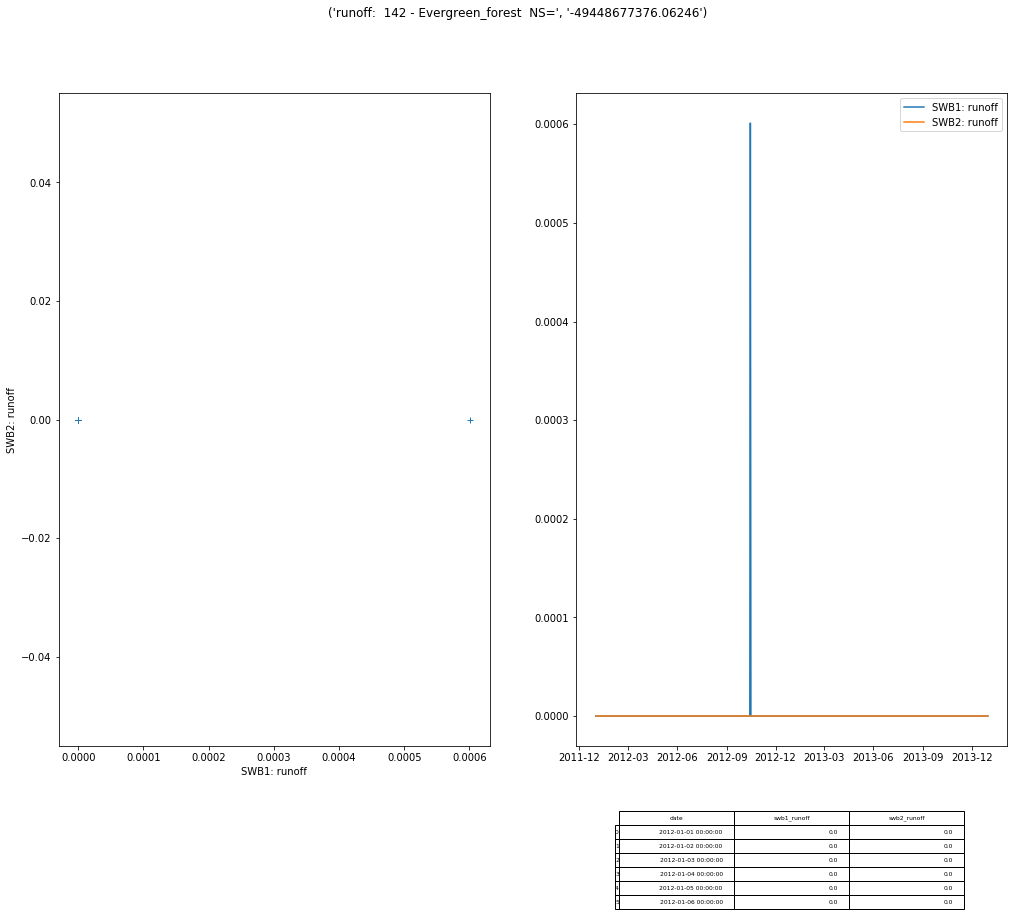

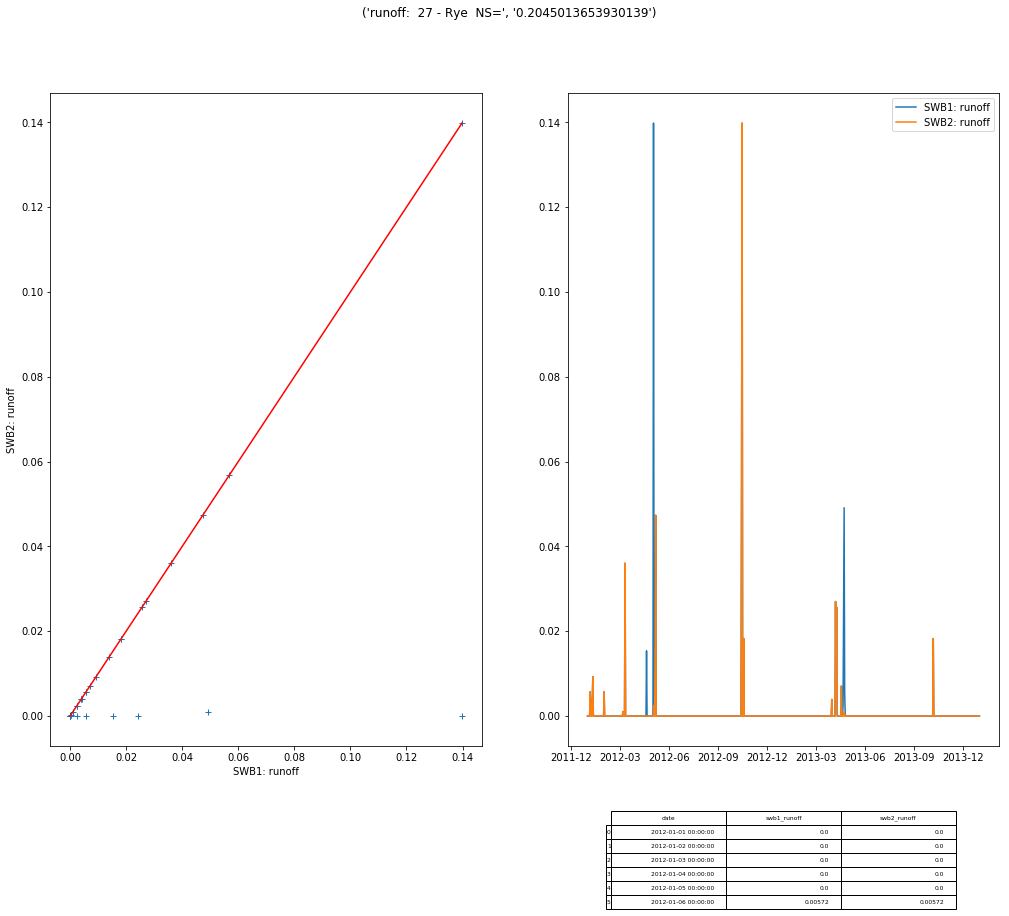

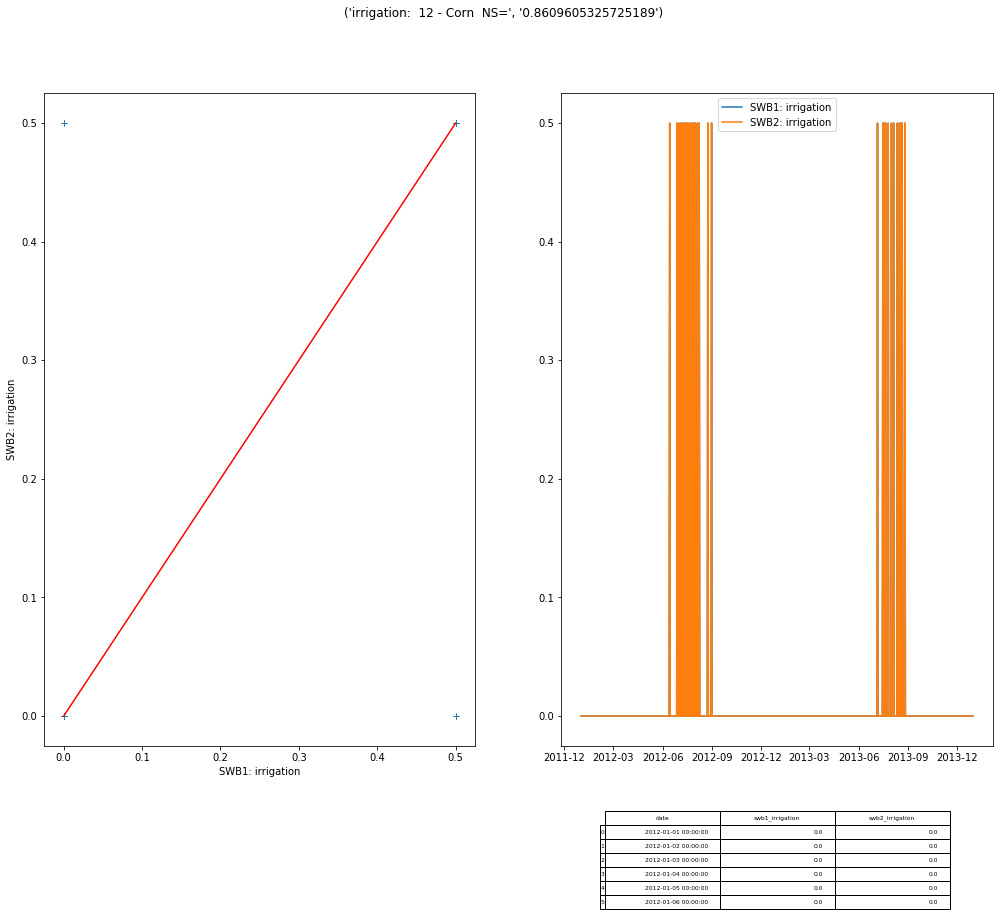

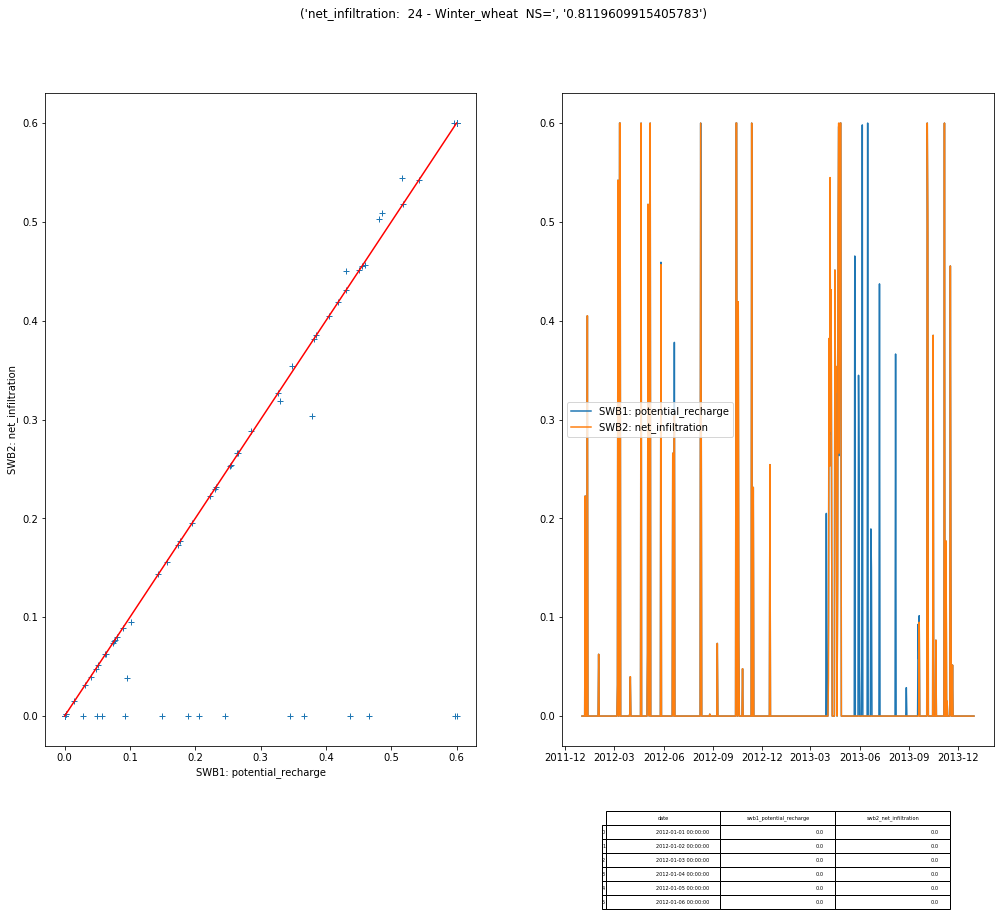

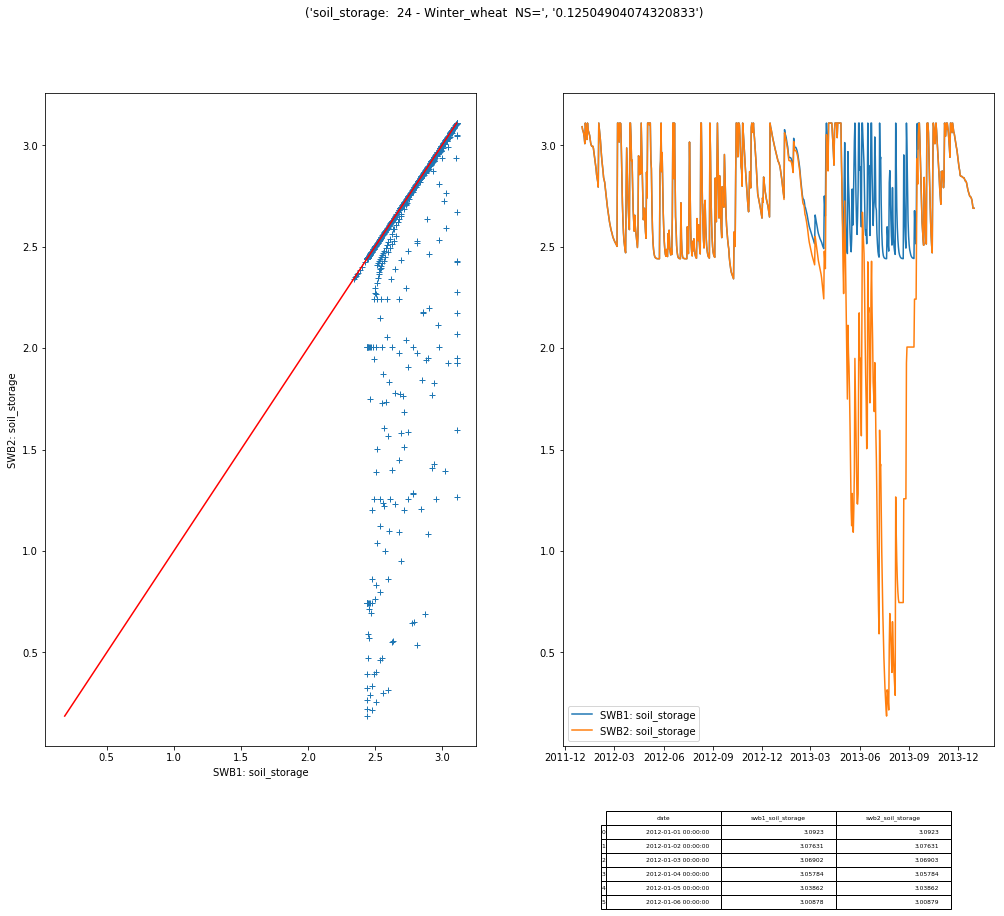

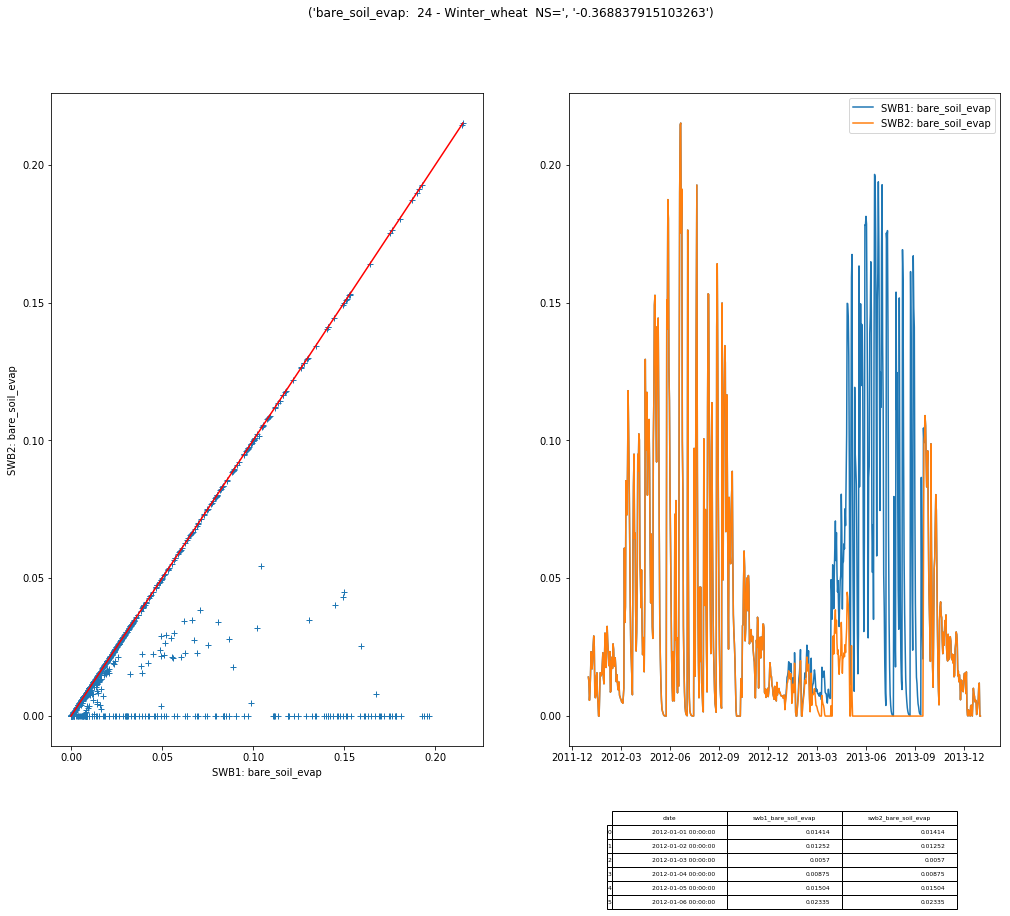

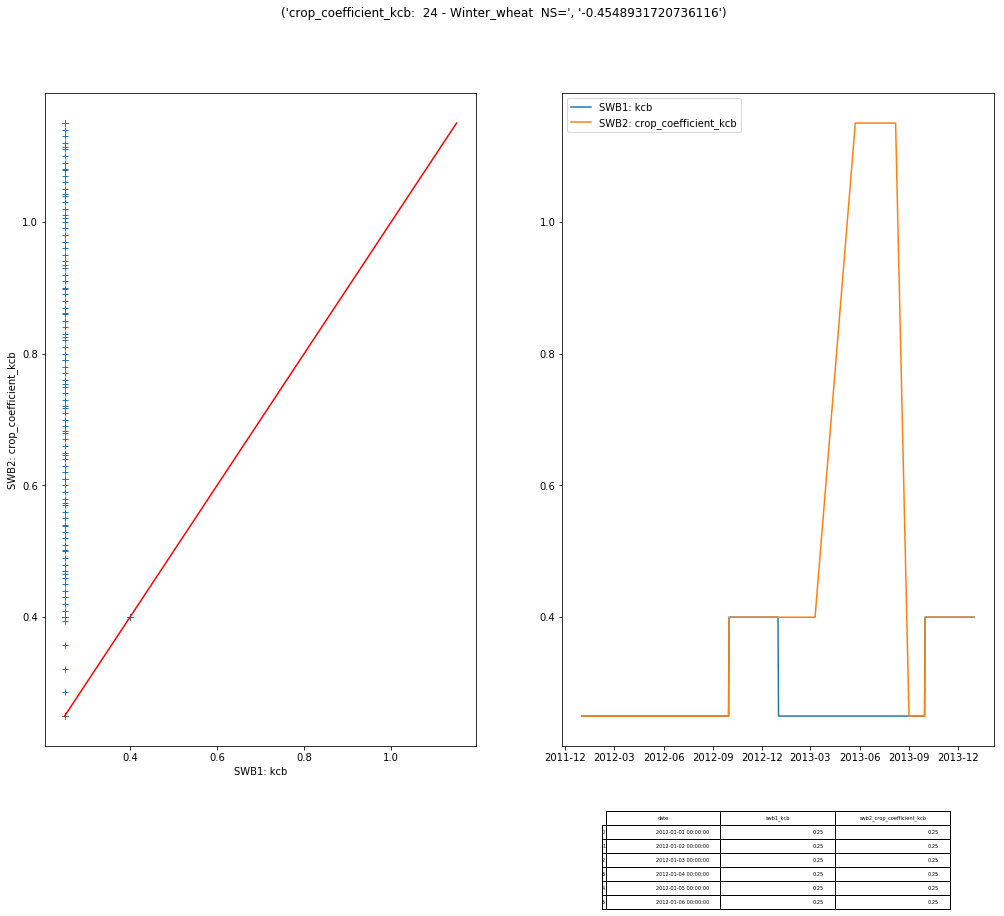

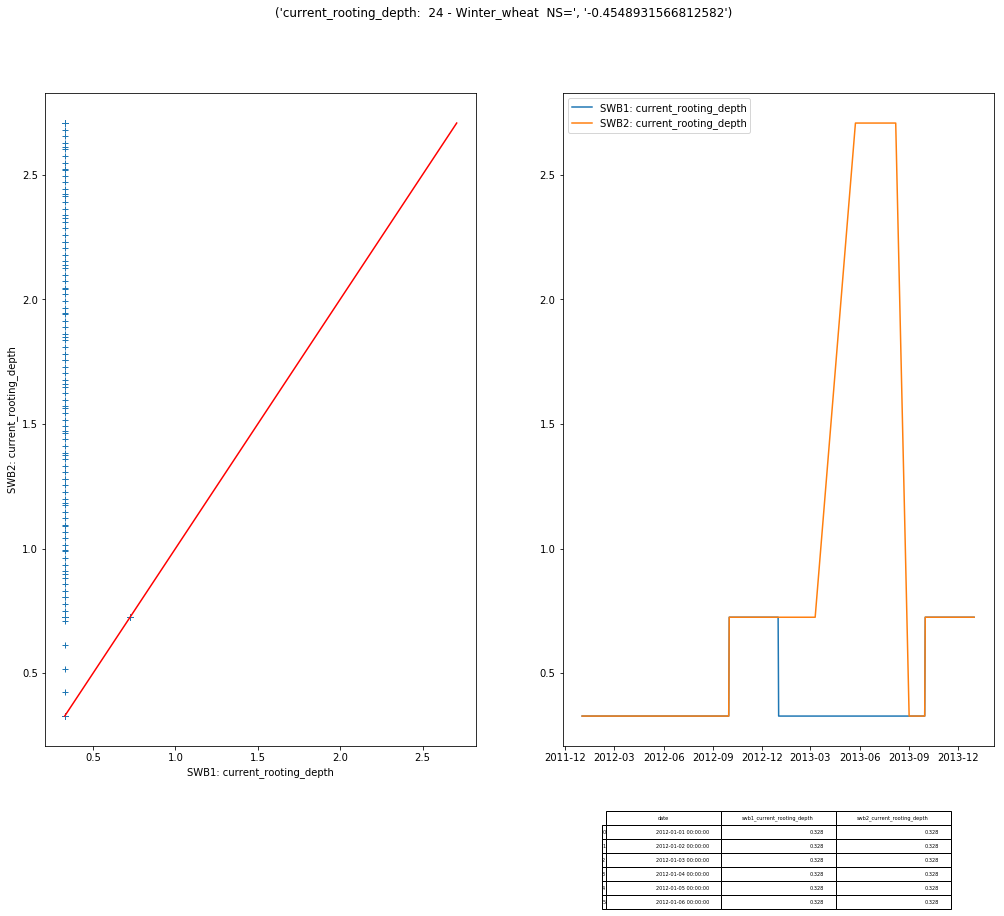

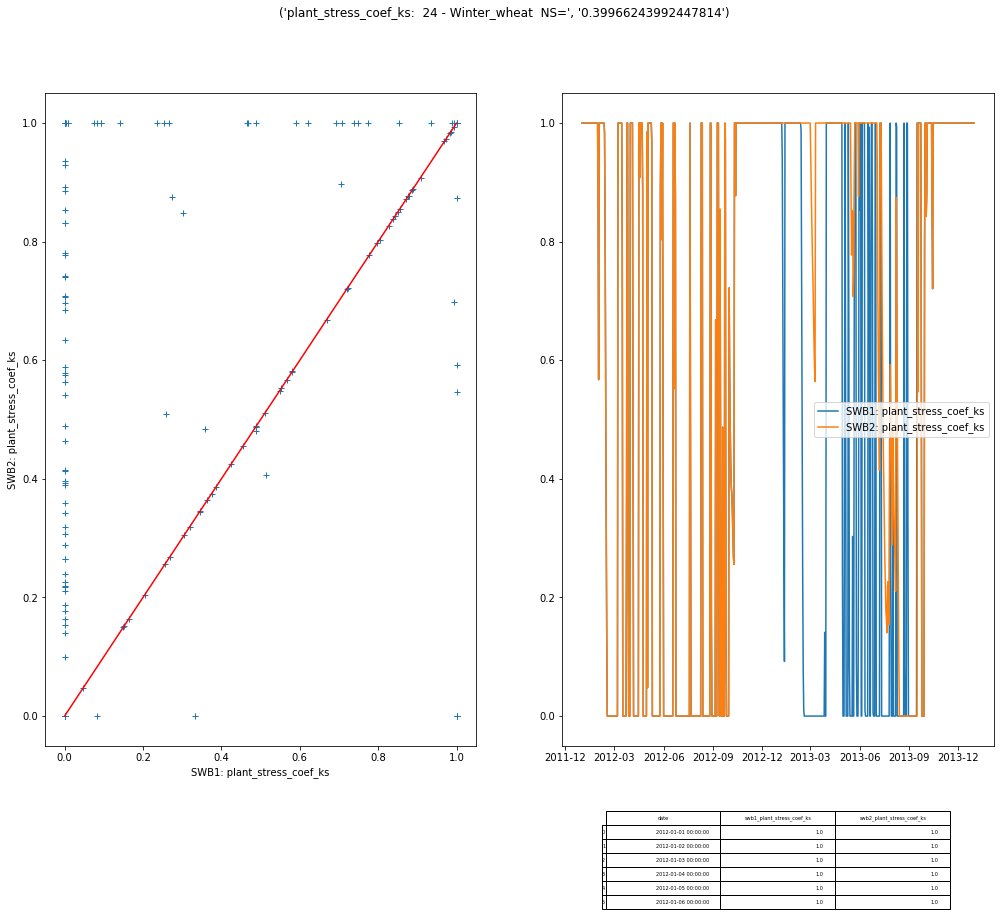

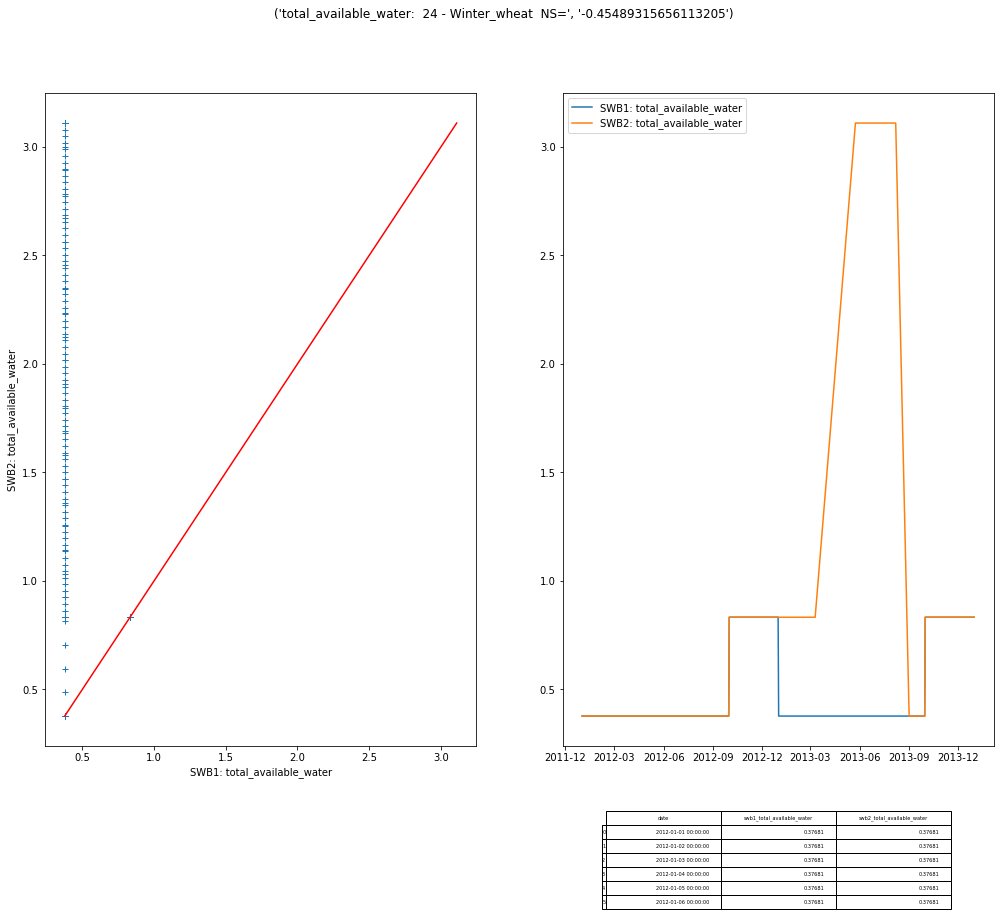

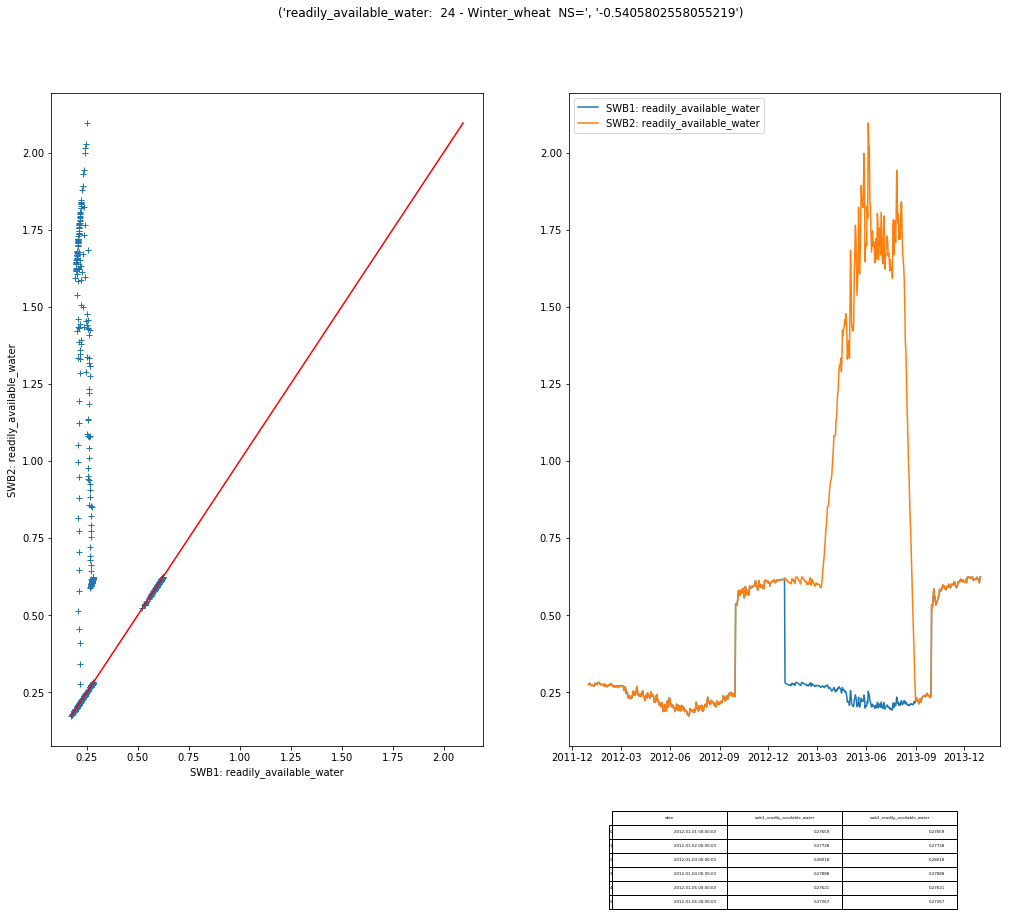

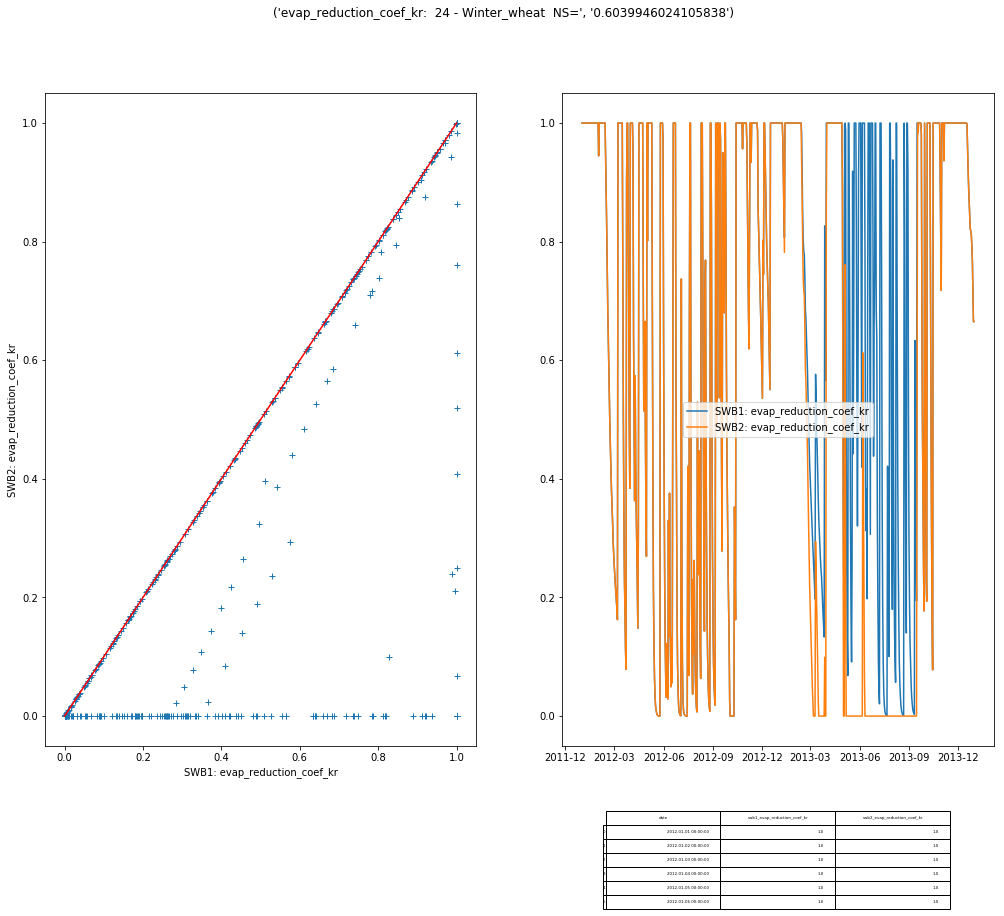

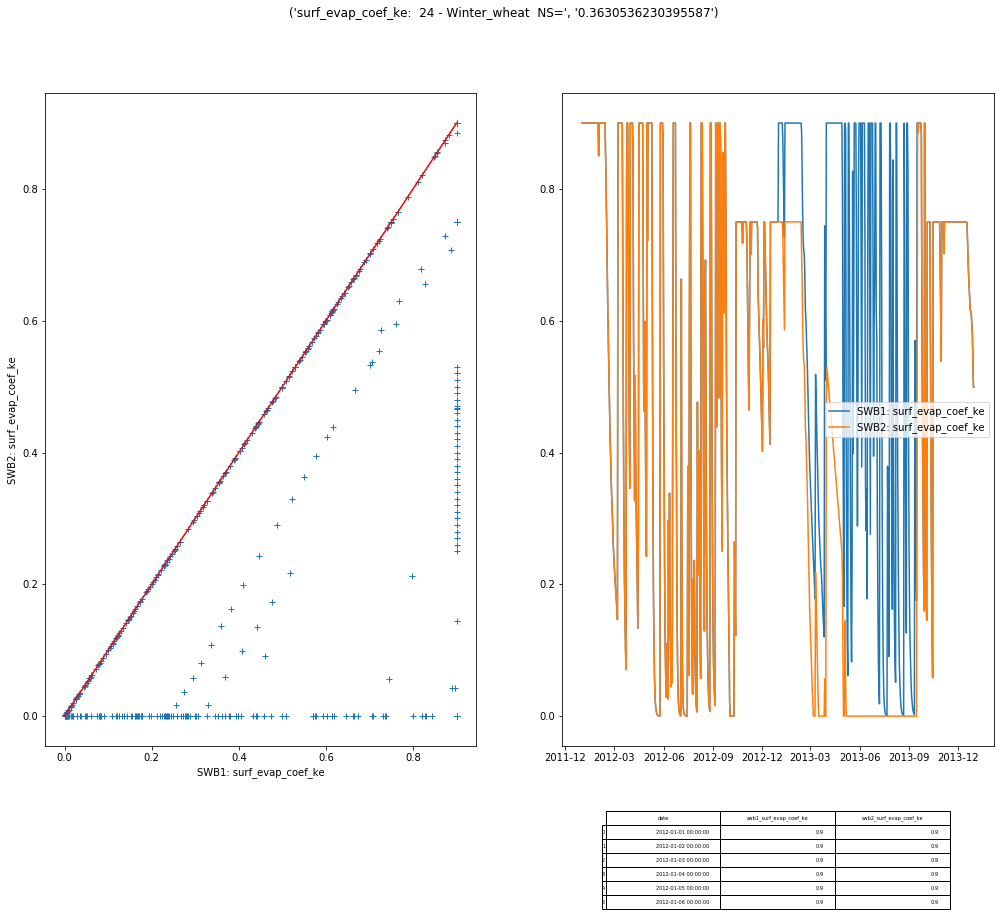

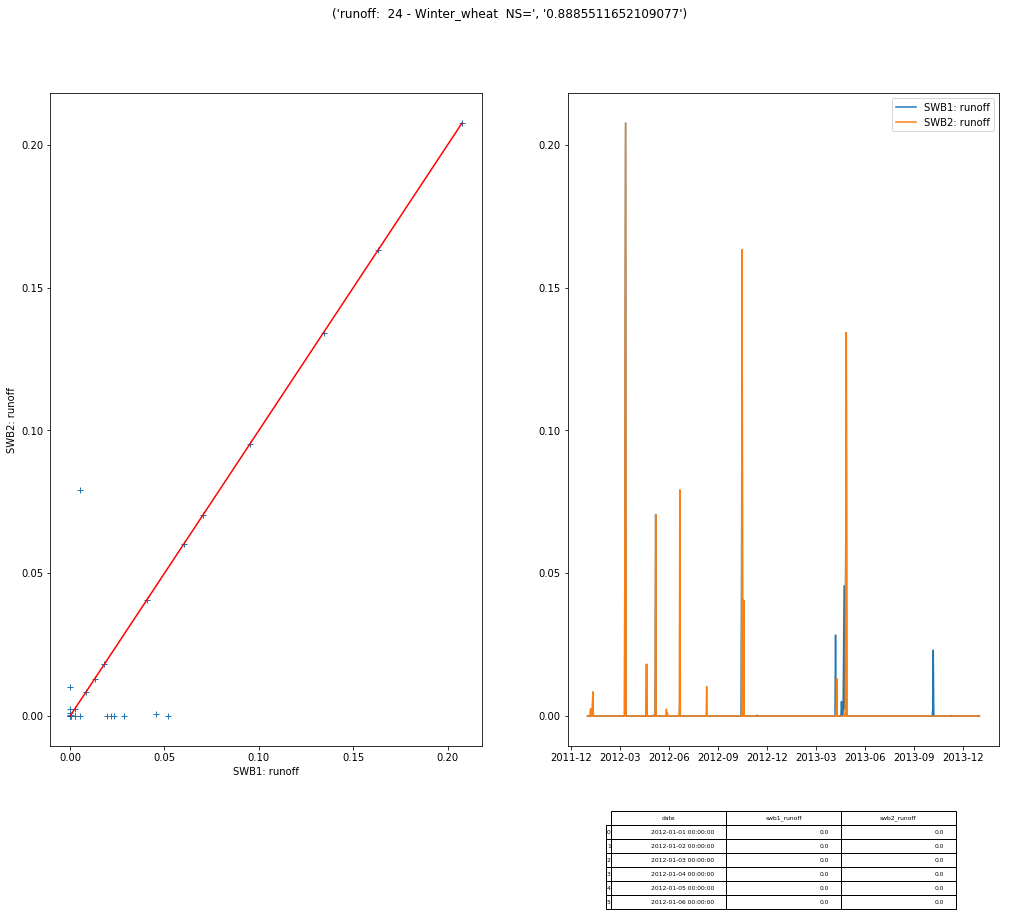

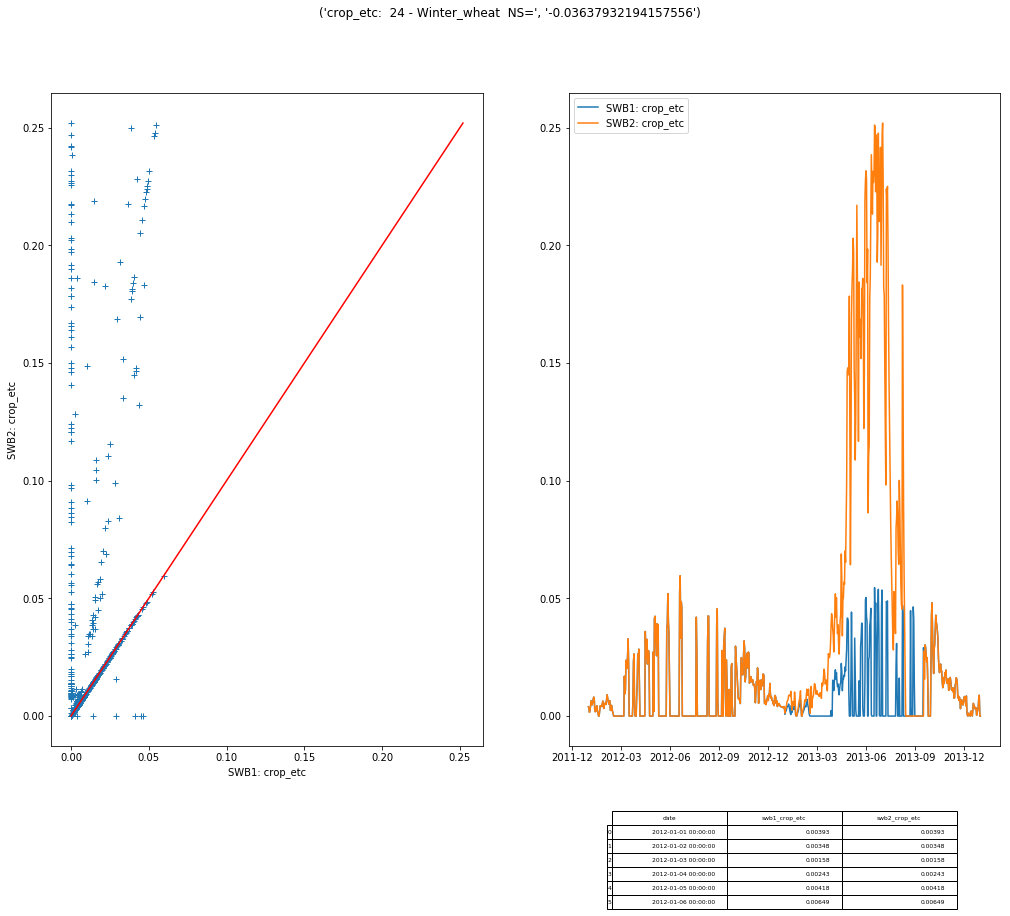

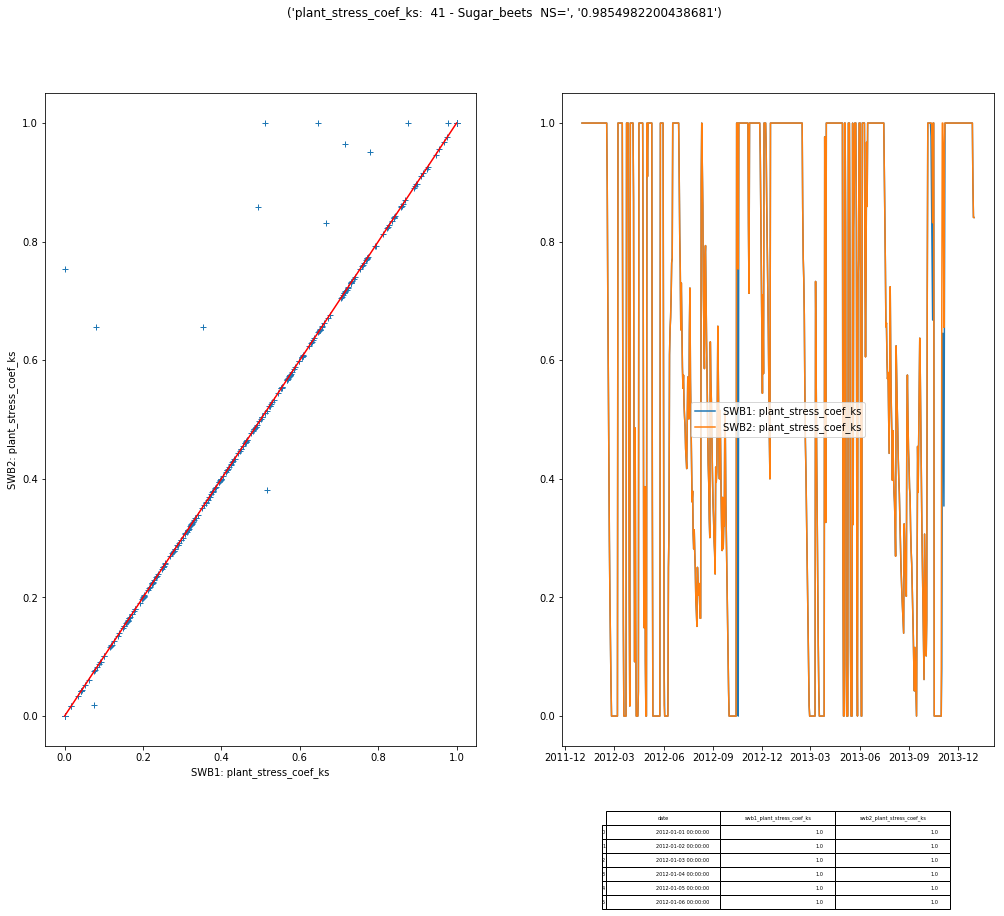

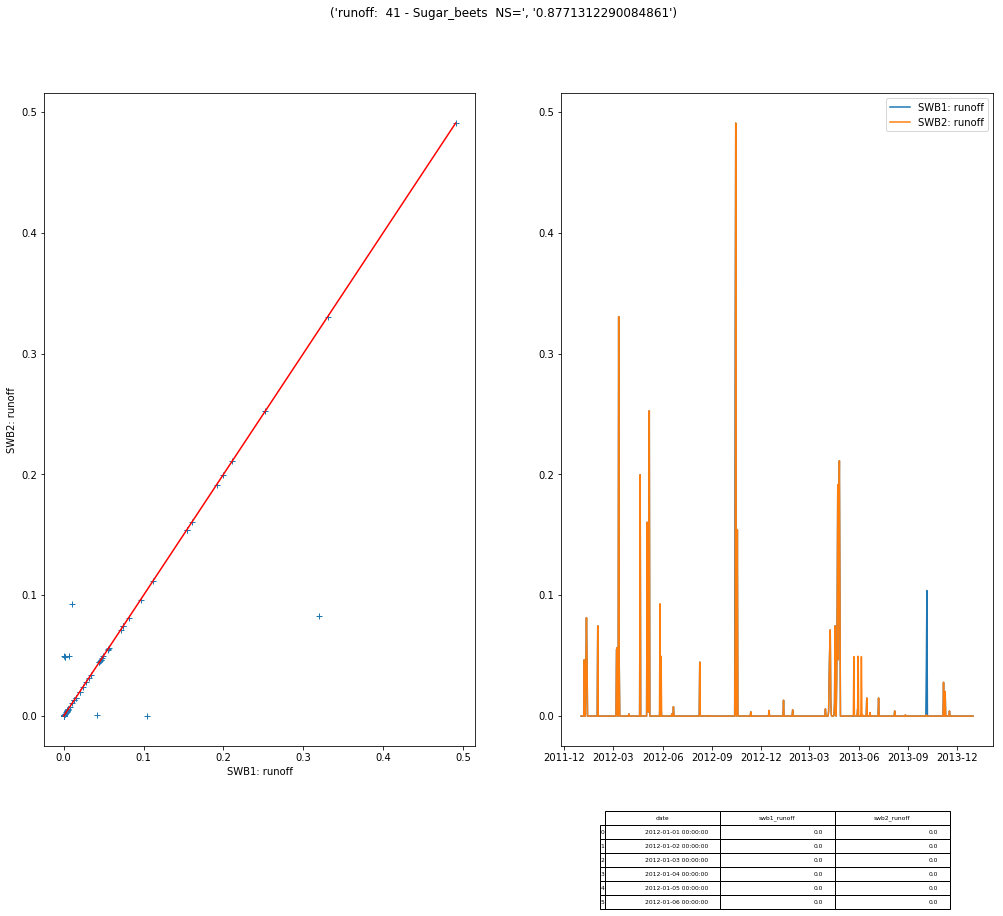

In [10]:
variable_pairs = soil_variable_pairs
for description,vals in comparison_cell_dict.items():
    print(description,vals)
    colnum = vals[0]
    rownum = vals[1]
    xcoord = vals[2]
    ycoord = vals[3]
    swb1_df = read_swb1_csv( colnum, rownum )
#    swb1_df = swb1_df.loc[swb1_df['date'].between('2012-12-01', '2013-03-31')]
    swb2_df = read_swb2_csv( colnum, rownum, xcoord, ycoord )
    swb2_df['gross_precip'] = swb2_df['rainfall'] + swb2_df['snowfall']
    make_plots( swb1_df, swb2_df, description )